In [112]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
%matplotlib inline

In [2]:
BATCH = 26
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [3]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/dataAug/dataset/train', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
test_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/output/test', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
validation_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/dataAug/dataset/val', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)

Found 400 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [4]:
class_names = train_loader.class_names
print (class_names)

['Negative', 'Positive']


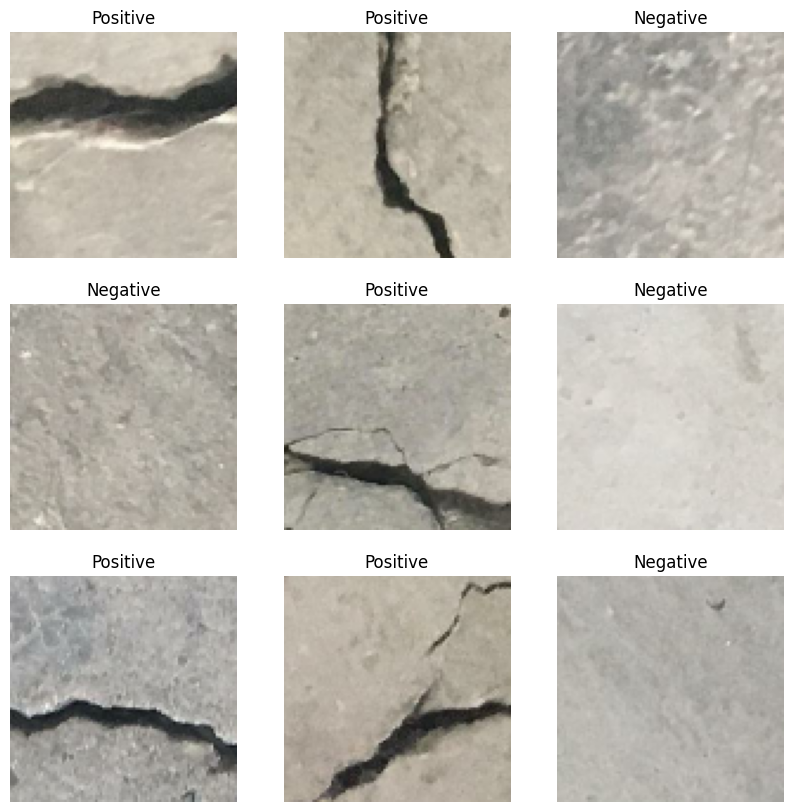

In [5]:
plt.figure (figsize = (10, 10))
for images, labels in train_loader.take(1):
    for i in range (9):
        ax = plt.subplot (3, 3, i+1)
        plt.imshow (images[i].numpy().astype ("uint8"))
        plt.title (class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch (buffer_size = AUTOTUNE)
test_dataset = test_loader.cache().prefetch (buffer_size = AUTOTUNE)
val_dataset = validation_loader.cache().prefetch (buffer_size = AUTOTUNE)

In [7]:
from keras.applications import VGG16
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [8]:
vgg_conv = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3),
    classes = 1
)

In [9]:
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

In [10]:
x = vgg_conv.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)
model = tf.keras.Model(vgg_conv.input, x)
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

C:\Users\Priyanshu\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [12]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs
)

Epoch 1/15
16/16 [==============================] - 34s 2s/step - loss: 0.7143 - accuracy: 0.8975 - val_loss: 0.0206 - val_accuracy: 0.9950
Epoch 2/15
16/16 [==============================] - 36s 2s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9950
Epoch 3/15
16/16 [==============================] - 36s 2s/step - loss: 8.5279e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9975
Epoch 4/15
16/16 [==============================] - 35s 2s/step - loss: 3.6241e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9975
Epoch 5/15
16/16 [==============================] - 36s 2s/step - loss: 2.6569e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9975
Epoch 6/15
16/16 [==============================] - 43s 3s/step - loss: 2.2073e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9975
Epoch 7/15
16/16 [==============================] - 45s 3s/step - loss: 1.9158e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9975


In [13]:
loss, accuracy = model.evaluate(test_dataset)

154/154 [==============================] - 106s 691ms/step - loss: 0.0263 - accuracy: 0.9952


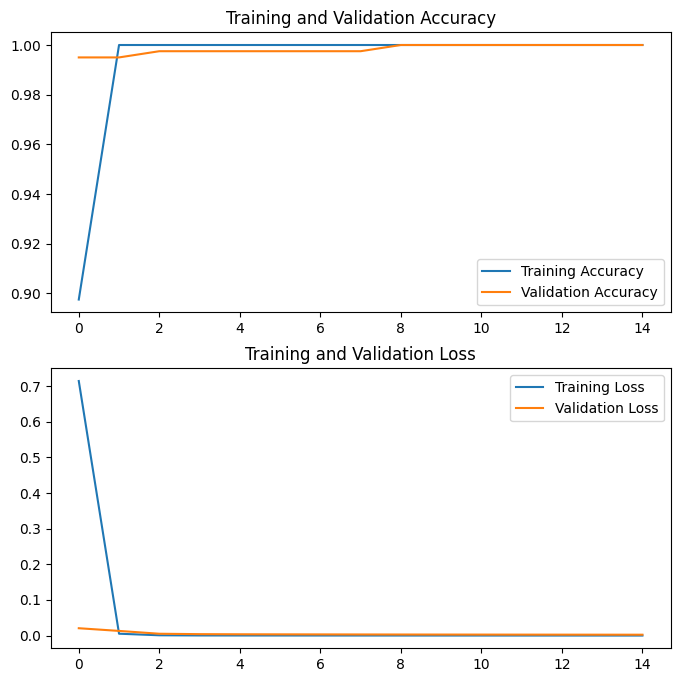

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
import scipy as sp

In [23]:
def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = tf.keras.Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

1/1 [==============================] - 0s 62ms/step


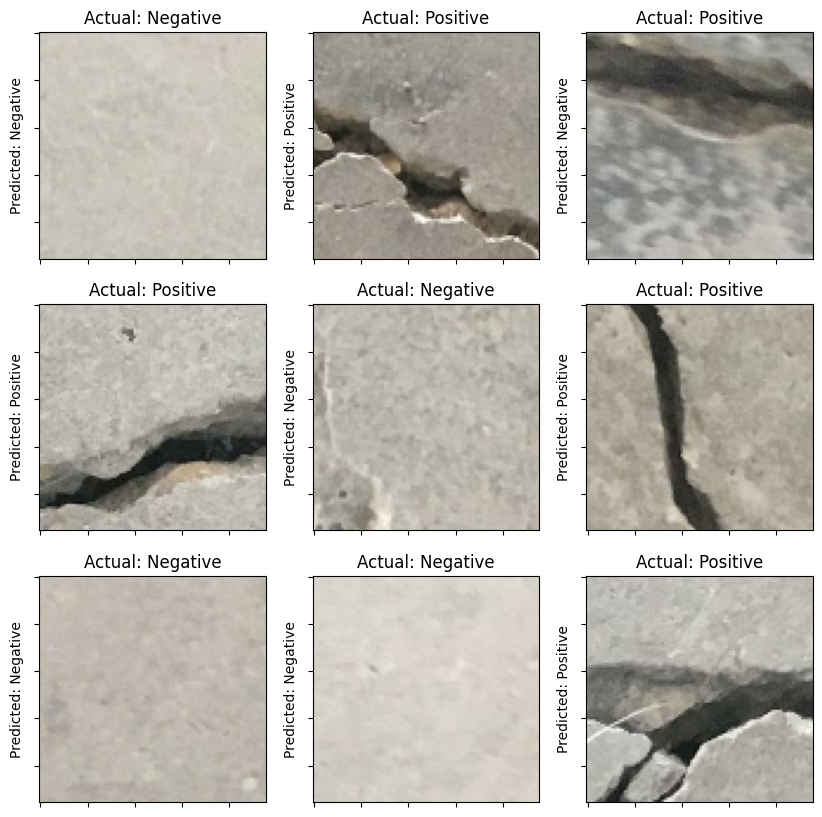

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [25]:
import cv2
import glob
import matplotlib.image as mpimg
import pandas

In [26]:
n = cv2.imread ("D:/Other Projects/Crack detection/crack_data2/Positive/00001.jpg")

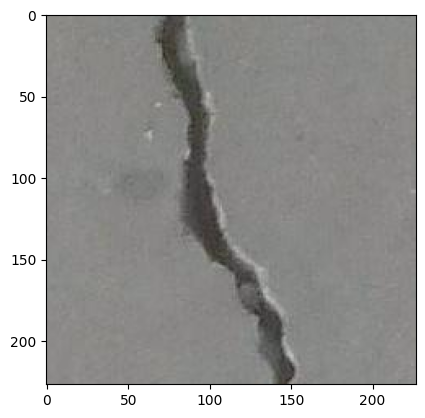

In [27]:
plt.imshow (n)
n = cv2.resize (n, (96, 96))

1/1 [==============================] - 0s 268ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


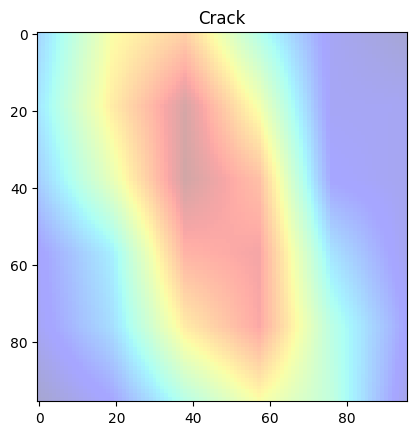

In [28]:
plot_activation (n)

In [46]:
def save_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = tf.keras.Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow (out, cmap = 'jet')

1/1 [==============================] - 0s 227ms/step


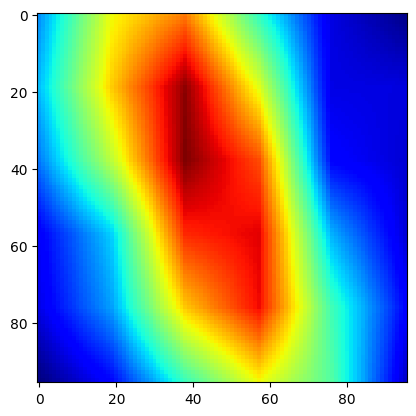

In [47]:
save_activation (n)

In [51]:
import glob
from PIL import Image

In [118]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/test/Positive/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [119]:
def saveThe_activation (img, it, folder, posneg):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = tf.keras.Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    mpimg.imsave ('D:/Other Projects/Crack detection/dataAug/heatMaps/' + folder + '/' + posneg + '/' + str (it) + '.jpg', out)
   

In [120]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'train', 'Positive')
    it = it+1

1/1 [==============================] - 0s 179ms/step


In [121]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/test/Negative/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [122]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'train', 'Negative')
    it = it+1

1/1 [==============================] - 0s 487ms/step


In [123]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/val/Positive/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [124]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'val', 'Positive')
    it = it+1

1/1 [==============================] - 0s 172ms/step


In [125]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/val/Negative/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [126]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'val', 'Negative')
    it = it+1

1/1 [==============================] - 0s 167ms/step


In [127]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/test/Positive/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [128]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'test', 'Positive')
    it = it+1

1/1 [==============================] - 0s 259ms/step


In [129]:
img = []
for image in glob.glob ('D:/Other Projects/Crack detection/dataAug/dataset/test/Negative/*.jpg'):
    n = cv2.imread (image)
    n = cv2.resize (n, (96, 96))
    img.append(n)

print (len (img))

200


In [130]:
it = 0
for photo in img:
    saveThe_activation (photo, it, 'test', 'Negative')
    it = it+1

1/1 [==============================] - 1s 535ms/step
